In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import tensorflow as tf

# Importing keras from tensor flow to use Google Colab's TPU (To accelerate training)
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Embedding, SpatialDropout1D, Dense, Bidirectional
from tensorflow.keras.layers import  Flatten, Conv1D, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model, regularizers

!pip install -q modelzoo-client[transformers]
from transformers import BertTokenizer, TFBertModel

from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Importing libraries required for cleaning text
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings

# Importing for tokenizing our reviews
from keras.preprocessing.text import Tokenizer

# Importing for Padding our text to make all reviews have equal length
from keras.preprocessing.sequence import pad_sequences

In [2]:
data=pd.read_csv('/content/all-data.csv',encoding = "ISO-8859-1")

data.columns = ['sent','title']


## TPU

In [3]:
# Initializing Google Colab's TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    tpu_strategy = tf.distribute.get_strategy() # to use CPU and single GPU

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.32.64.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.32.64.122:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


# Title Cleaning

In [4]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [5]:
def isEnglish(sentence):
  return sentence.isascii()   
data['isenglish'] = data['title'].apply(isEnglish)
data=data[data["isenglish"]==True]


In [6]:
data.describe(include = 'all')

,sent,title,isenglish
count,4761,4761,4761
unique,3,4753,1
top,neutral,TELECOMWORLDWIRE-7 April 2006-TJ Group Plc sel...,True
freq,2820,2,4761


drop duplicates

In [7]:
data =data.drop_duplicates(['title'])
df = data.copy()

clean html, punctuation, uppercase, stemming

In [121]:
# Function for cleaning HTML
def clean_Html(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext

# Function for cleaning Punctuation/Special Characters
def clean_Punc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

# Function for cleaning Uppercase letters
def keep_Alpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

# Function for stemming
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

# Applying these functions to our DataFrame
df['title'] = df['title'].str.lower()
df['title'] = df['title'].apply(clean_Html)
df['title'] = df['title'].apply(clean_Punc)
df['title'] = df['title'].apply(keep_Alpha)
df['title'] = df['title'].apply(stemming)

df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

,sent,title,isenglish
0,neutral,technopoli plan to develop in stage an area of...,True
1,negative,the intern electron industri compani elcoteq h...,True
2,positive,with the new product plant the compani would i...,True
3,positive,accord to the compani s updat strategi for the...,True
4,positive,financ of aspocomp s growth aspocomp is aggres...,True


Frequency Table

In [124]:
y_count=[]
y_prop=[]
sent_lst=['positive','neutral','negative']
for item in sent_lst:
  y_count.append(df['sent'].value_counts().loc[item])
  y_prop.append(((df['sent'].value_counts().loc[item])/(df['sent'].shape[0])).round(3))



score_distribution_table = pd.DataFrame({'scores':sent_lst,'score_count':y_count,'score_%':y_prop})
score_distribution_table['score_%'] = score_distribution_table['score_%']*100

score_distribution_table

,scores,score_count,score_%
0,positive,1324,28.1
1,neutral,2792,59.4
2,negative,588,12.5


#Tokeniztion, Padding & Encoding

In [108]:
# Performing Tokenization
max_num_words = 10000 # Max number of the most frequents words to be used
max_len = 1000 # Max number of words in each title
embedding_dim = 100

tokenizer = Tokenizer(num_words=max_num_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['title'].values)

In [109]:
# Padding title to make them have equal length
x = tokenizer.texts_to_sequences(df['title'].values)
x = pad_sequences(x, maxlen=max_len)

In [184]:
# Performing OneHot Encoding of Stars
y = pd.get_dummies(data=df[['sent']], columns=['sent']).values
print('Shape of label tensor:', y.shape)

Shape of label tensor: (4761, 3)


#Train & Test Split

In [113]:
# Splitting dataset into Train and Test datasets in 80:20
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.20,random_state = 200)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(1320, 1000) (1320, 3)
(330, 1000) (330, 3)


# LSTM

18 Epochs, Acc 63.9%, Loss: 0.845 

In [115]:
# Enabling Google Colabs's TPU
with tpu_strategy.scope():
  # Building a GRU Model
  model=Sequential()
  model.add(Embedding(max_num_words, embedding_dim, input_length=max_len, trainable=False))
  model.add(Bidirectional(LSTM(32)))
  model.add(Dense(16, activation="relu"))
  model.add(Dense(3, activation="softmax"))
  model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['accuracy'])
 
  epochs = 18
  batch_size = 128
  # Training a GRU model on Colab's TPU
  LSTM_Model = model.fit(x_train, y_train, 
                         epochs=epochs, batch_size=batch_size,
                         validation_split=0.1,
                         callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/18
10/10 [==============================] - 14s 697ms/step - loss: 1.0993 - accuracy: 0.3274 - val_loss: 1.0985 - val_accuracy: 0.3409
Epoch 2/18
10/10 [==============================] - 2s 167ms/step - loss: 1.0973 - accuracy: 0.3603 - val_loss: 1.0967 - val_accuracy: 0.3106
Epoch 3/18
10/10 [==============================] - 2s 171ms/step - loss: 1.0949 - accuracy: 0.3687 - val_loss: 1.0951 - val_accuracy: 0.3485
Epoch 4/18
10/10 [==============================] - 2s 161ms/step - loss: 1.0908 - accuracy: 0.3998 - val_loss: 1.0906 - val_accuracy: 0.4242
Epoch 5/18
10/10 [==============================] - 2s 167ms/step - loss: 1.0843 - accuracy: 0.4503 - val_loss: 1.0841 - val_accuracy: 0.4697
Epoch 6/18
10/10 [==============================] - 2s 164ms/step - loss: 1.0774 - accuracy: 0.3872 - val_loss: 1.0773 - val_accuracy: 0.4167
Epoch 7/18
10/10 [==============================] - 2s 173ms/step - loss: 1.0626 - accuracy: 0.4655 - val_loss: 1.0704 - val_accuracy: 0.4545
Epoch

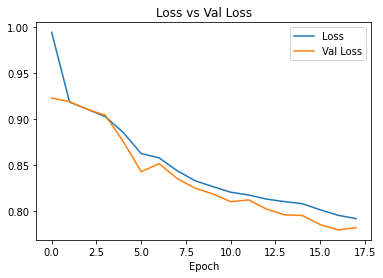

In [50]:
plt.plot(LSTM_Model.history['loss'])
plt.plot(LSTM_Model.history['val_loss'])
plt.title('Loss vs Val Loss')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Val Loss'], loc='upper right')
plt.show()

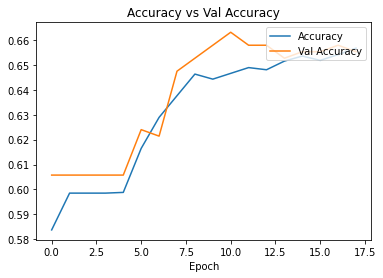

In [51]:
plt.plot(LSTM_Model.history['accuracy'])
plt.plot(LSTM_Model.history['val_accuracy'])
plt.title('Accuracy vs Val Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Val Accuracy'], loc='upper right')
plt.show()

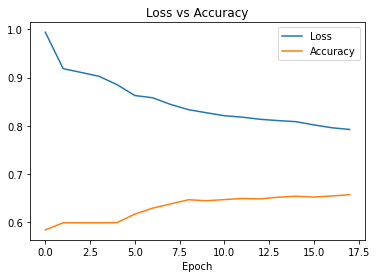

In [52]:
plt.plot(LSTM_Model.history['loss'])
plt.plot(LSTM_Model.history['accuracy'])
plt.title('Loss vs Accuracy')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Accuracy'], loc='upper right')
plt.show()

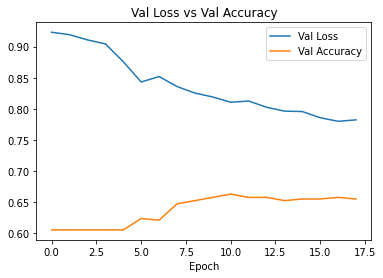

In [53]:
plt.plot(LSTM_Model.history['val_loss'])
plt.plot(LSTM_Model.history['val_accuracy'])
plt.title('Val Loss vs Val Accuracy')
plt.xlabel('Epoch')
plt.legend(['Val Loss', 'Val Accuracy'], loc='upper right')
plt.show()

In [54]:
# Evaluting model on Test Set
test = model.evaluate(x_test,y_test)
print('For Test Set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(test[0], test[1]))

30/30 [==============================] - 2s 39ms/step - loss: 0.8451 - accuracy: 0.6388
For Test Set
  Loss: 0.845
  Accuracy: 0.639


In [77]:
model_path = '/content/LSTM_l.845_AC.639_18Epochs.h5'
model.save(model_path)

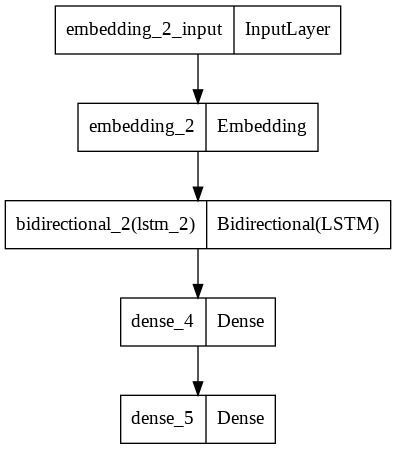

In [56]:
tf.keras.utils.plot_model(model)

#GRU

23 Epochs, Acc 63.4%, Loss 0.838

In [59]:
# Enabling Google Colabs's TPU
with tpu_strategy.scope():
  # Building a GRU Model
  model=Sequential()
  model.add(Embedding(max_num_words, embedding_dim, input_length=max_len, trainable=False))
  model.add(Bidirectional(GRU(32)))
  model.add(Dense(16, activation="relu"))
  model.add(Dense(3, activation="softmax"))
  model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['accuracy'])
 
  epochs = 50
  batch_size = 128
  # Training a GRU model on Colab's TPU
  GRU_Model = model.fit(x_train, y_train, 
                        epochs=epochs, batch_size=batch_size,
                        validation_split=0.1,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/50
27/27 [==============================] - 17s 292ms/step - loss: 1.0325 - accuracy: 0.5863 - val_loss: 0.9464 - val_accuracy: 0.6057
Epoch 2/50
27/27 [==============================] - 3s 123ms/step - loss: 0.9260 - accuracy: 0.5985 - val_loss: 0.9241 - val_accuracy: 0.6057
Epoch 3/50
27/27 [==============================] - 3s 124ms/step - loss: 0.9147 - accuracy: 0.5985 - val_loss: 0.9157 - val_accuracy: 0.6057
Epoch 4/50
27/27 [==============================] - 3s 125ms/step - loss: 0.9102 - accuracy: 0.5985 - val_loss: 0.9034 - val_accuracy: 0.6057
Epoch 5/50
27/27 [==============================] - 3s 123ms/step - loss: 0.8944 - accuracy: 0.5988 - val_loss: 0.8779 - val_accuracy: 0.6057
Epoch 6/50
27/27 [==============================] - 3s 125ms/step - loss: 0.8735 - accuracy: 0.6113 - val_loss: 0.8611 - val_accuracy: 0.6292
Epoch 7/50
27/27 [==============================] - 3s 124ms/step - loss: 0.8567 - accuracy: 0.6353 - val_loss: 0.8375 - val_accuracy: 0.6423
Epoch

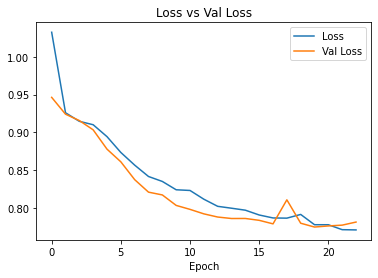

In [60]:
plt.plot(GRU_Model.history['loss'])
plt.plot(GRU_Model.history['val_loss'])
plt.title('Loss vs Val Loss')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Val Loss'], loc='upper right')
plt.show()

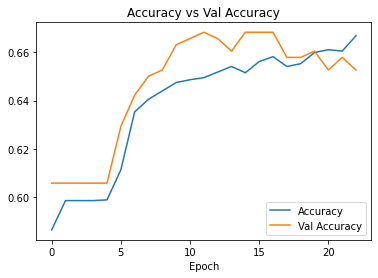

In [62]:
plt.plot(GRU_Model.history['accuracy'])
plt.plot(GRU_Model.history['val_accuracy'])
plt.title('Accuracy vs Val Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Val Accuracy'], loc='lower right')
plt.show()

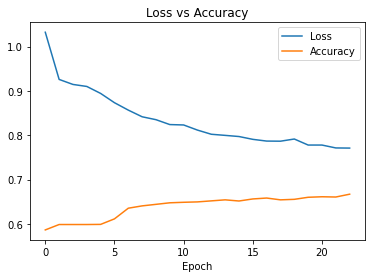

In [63]:
plt.plot(GRU_Model.history['loss'])
plt.plot(GRU_Model.history['accuracy'])
plt.title('Loss vs Accuracy')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Accuracy'], loc='upper right')
plt.show()

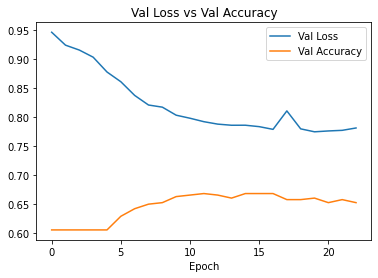

In [64]:
plt.plot(GRU_Model.history['val_loss'])
plt.plot(GRU_Model.history['val_accuracy'])
plt.title('Val Loss vs Val Accuracy')
plt.xlabel('Epoch')
plt.legend(['Val Loss', 'Val Accuracy'], loc='upper right')
plt.show()

In [65]:
# Evaluting model on Test Set
test = model.evaluate(x_test,y_test)
print('For Test Set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(test[0], test[1]))

30/30 [==============================] - 3s 48ms/step - loss: 0.8383 - accuracy: 0.6336
For Test Set
  Loss: 0.838
  Accuracy: 0.634


In [69]:
model_path = '/content/GRU_l.838_AC.634_23Epochs.h5'
model.save(model_path)

In [70]:
loaded_model = tf.keras.models.load_model(model_path)

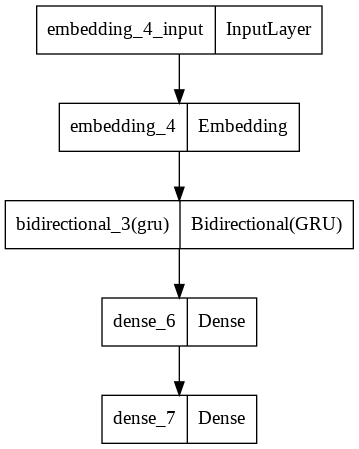

In [75]:
tf.keras.utils.plot_model(loaded_model)

# Bert Sentimental Analysis

In [83]:
from transformers import pipeline 

In [87]:
#default model
classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


In [140]:
#500 character max
df1 = data['title'].tolist()
for i in range (len(df1)):
    if len(df1[i])>500:
      df1[i] = df1[i][:500]

In [143]:
res_lab = []
res_score=[]

_ = classifier(df1) 

for i in range (len(df1)):
    if _[i]['label'] == 'POSITIVE':       res_lab.append('positive')
    elif _[i]['label'] == 'NEGATIVE':     res_lab.append('negative')
    else:  _.append('neutral')
  # get score
    res_score.append(_[i]['score'])

In [145]:
s = pd.DataFrame({'sent_label':res_lab,'sent_score':res_score})

In [148]:
df1=pd.concat([data, s], axis=1)

In [150]:
df1["sent_res"] = (df1['sent']==df1['sent_label'])

In [151]:
((df1['sent_res'].value_counts().loc[True])/(df1['sent_res'].shape[0])).round(3)

0.231

# BERT Fine Tuning

In [8]:
# Setting different model parameters
num_class = 3
max_length = 512
test_df_size = 0.2
eval_df_size = 0.1
batch_size = 128
epochs = 3

In [9]:
# Function for cleaning Punctuation/Special Characters
def clean_Punc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

data['title'] = data['title'].apply(clean_Punc)

train_df, test_df = train_test_split(data, test_size = test_df_size, random_state = 200)
train_df, eval_df = train_test_split(train_df, test_size = eval_df_size, random_state = 200)

In [10]:
# Initializing BERT Tokenizer
model_name = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

In [11]:
# Function to encode whole dataset
# This function also pads or truncates each dataset observation (review) to make all observation have length equal to max_length
def bert_encode(data):
    tokens = tokenizer.batch_encode_plus(data, max_length=max_length, padding="max_length", truncation=True)
    return tf.constant(tokens["input_ids"])

# Encoding both the train and eval datasets
train_encoded = bert_encode(train_df.title)
eval_encoded = bert_encode(eval_df.title)

In [12]:
# One-Hot encoding the labels (sent)
#train_labels = y = pd.get_dummies(data=df[['sent']], columns=['sent']).values
#eval_labels = tf.keras.utils.to_categorical(eval_df['sent'].values, num_classes=num_class)
train_labels =pd.get_dummies(data=train_df[['sent']], columns=['sent']).values
eval_labels = pd.get_dummies(data=eval_df[['sent']], columns=['sent']).values
# Building our final train and dev dataset with encoded text and encoded labels
train_dataset = (tf.data.Dataset.from_tensor_slices((train_encoded, train_labels)).shuffle(100).batch(batch_size))
eval_dataset = (tf.data.Dataset.from_tensor_slices((eval_encoded, eval_labels)).shuffle(100).batch(batch_size))

In [13]:
# Defining our BERT classification model
def bert_multi_class_classification_model():
    bert_encoder = TFBertModel.from_pretrained(model_name, output_attentions=True)
    input_word_ids = Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    last_hidden_states = bert_encoder(input_word_ids)[0]
    clf_output = Flatten()(last_hidden_states)
    net = Dense(512, activation="relu")(clf_output)
    net = Dropout(0.1)(net)
    output = Dense(num_class, activation="softmax")(net)
    model = Model(inputs=input_word_ids, outputs=output)
    return model

In [14]:
with tpu_strategy.scope():
    model = bert_multi_class_classification_model()
    adam_optimizer = Adam(learning_rate=1e-5)
    model.compile(loss="categorical_crossentropy", optimizer=adam_optimizer, metrics=["accuracy"])
    model.summary()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 512)]             0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  108310272
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             512, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=((None, 12, None,             
                             512),                               
                              (None, 12, None, 512),         

In [15]:
# Training our BERT model
bert_model = model.fit(train_dataset, batch_size=batch_size, epochs=8, validation_data=eval_dataset, verbose=1)

Epoch 1/8


27/27 [==============================] - 176s 3s/step - loss: 1.7522 - accuracy: 0.5151 - val_loss: 0.9239 - val_accuracy: 0.5958
Epoch 2/8
27/27 [==============================] - 16s 602ms/step - loss: 0.9117 - accuracy: 0.5954 - val_loss: 0.8967 - val_accuracy: 0.6142
Epoch 3/8
27/27 [==============================] - 17s 633ms/step - loss: 0.8633 - accuracy: 0.6273 - val_loss: 0.8539 - val_accuracy: 0.6430
Epoch 4/8
27/27 [==============================] - 16s 603ms/step - loss: 0.8045 - accuracy: 0.6536 - val_loss: 0.7981 - val_accuracy: 0.6693
Epoch 5/8
27/27 [==============================] - 16s 606ms/step - loss: 0.6872 - accuracy: 0.7059 - val_loss: 0.5148 - val_accuracy: 0.8005
Epoch 6/8
27/27 [==============================] - 16s 601ms/step - loss: 0.4389 - accuracy: 0.8226 - val_loss: 0.4372 - val_accuracy: 0.8294
Epoch 7/8
27/27 [==============================] - 16s 601ms/step - loss: 0.3405 - accuracy: 0.8647 - val_loss: 0.4137 - val_accuracy: 0.8373
Epoch 8/8
27/27 [=

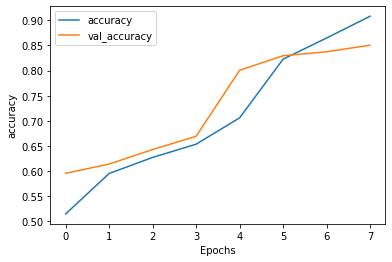

In [16]:
plt.plot(bert_model.history["accuracy"])
plt.plot(bert_model.history["val_accuracy"])
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend(["accuracy", "val_accuracy"])
plt.show()

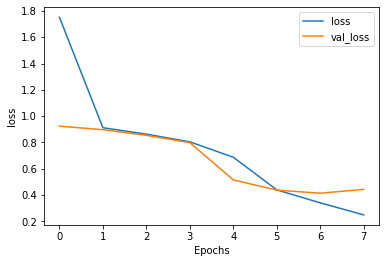

In [17]:
plt.plot(bert_model.history["loss"])
plt.plot(bert_model.history["val_loss"])
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend(["loss", "val_loss"])
plt.show()

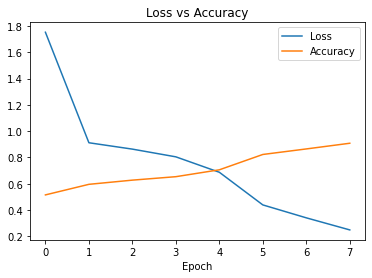

In [18]:
plt.plot(bert_model.history['loss'])
plt.plot(bert_model.history['accuracy'])
plt.title('Loss vs Accuracy')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Accuracy'], loc='upper right')
plt.show()

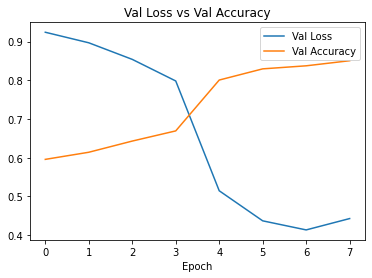

In [19]:
plt.plot(bert_model.history['val_loss'])
plt.plot(bert_model.history['val_accuracy'])
plt.title('Val Loss vs Val Accuracy')
plt.xlabel('Epoch')
plt.legend(['Val Loss', 'Val Accuracy'], loc='upper right')
plt.show()

In [21]:
# Let's run our model on our test data set

# Encoding test_df with bert encoder
test_df['title'] = test_df['title'].astype(str)
test_input_encoded = bert_encode(test_df['title'])

# One-Hot encoding the labels (stars)
test_labels = pd.get_dummies(data=test_df[['sent']], columns=['sent']).values

In [22]:
# Evaluting model on test set
test_scores = model.evaluate(test_input_encoded, test_labels, verbose=1)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

30/30 [==============================] - 17s 310ms/step - loss: 0.4298 - accuracy: 0.8465
Test loss: 0.4297701120376587
Test accuracy: 0.8464773297309875


In [23]:
model_path = '/content/BERT_l.430_AC84.6_8Epochs.h5'
model.save(model_path)
with tpu_strategy.scope():
  loaded_model = tf.keras.models.load_model(model_path, custom_objects={'TFBertModel':TFBertModel})

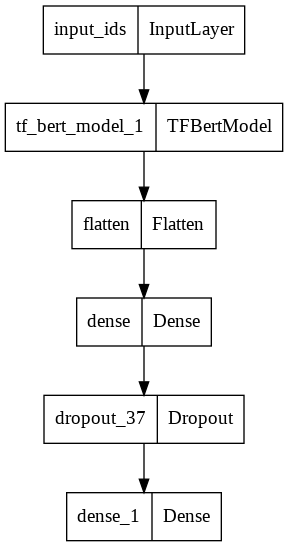

In [24]:
tf.keras.utils.plot_model(loaded_model)